# Introduction

#### Choice of the dataset

We have chosen to use the **offensive dataset** because the **hate dataset** has a **CC BY-NC 4.0 license**, which does **not authorize** its use for **commercial purposes**.

# Evaluating the dataset

## 1. Dataset description

In [7]:
!pip install -q datasets bertopic umap evaluate xformers shap scikit-learn statsmodels

In [8]:
import csv
import evaluate
import shap
import json
import torch
import numpy as np
import pandas as pd
import urllib.request

from termcolor import colored
from IPython.display import Markdown, display
from datasets import load_dataset
from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [9]:
tweet_dataset = load_dataset("tweet_eval",'offensive')

  0%|          | 0/3 [00:00<?, ?it/s]

Let's take a look at the dataset split :

In [10]:
tweet_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

The dataset contains **14100 labelled texts** distributed as follows :
- **`Train set`** : **85%** of the dataset
- **`Test set`** : **6%** of the dataset
- **`Validation set`** : **9%** of the dataset

For offensive config:

- **`Text`** : a string feature containing the tweet.

- **`Label`** : an int classification label with the following mapping: **0: non-offensive**, **1: offensive**

In [11]:
display(Markdown("**Train dataset:**"))
print("Non-offensive: ", tweet_dataset['train']['label'].count(0),
      ", Offensive : ", tweet_dataset['train']['label'].count(1))

display(Markdown("**Test dataset:**"))
print("Non-offensive:", tweet_dataset['test']['label'].count(0),
      ", Offensive : ", tweet_dataset['test']['label'].count(1))

display(Markdown("**Validation dataset:**"))
print("Non-offensive: ", tweet_dataset['validation']['label'].count(0),
      ", Offensive : ", tweet_dataset['validation']['label'].count(1))

**Train dataset:**

Non-offensive:  7975 , Offensive :  3941


**Test dataset:**

Non-offensive: 620 , Offensive :  240


**Validation dataset:**

Non-offensive:  865 , Offensive :  459


Looking at the data, we can see that there is **more non-offensive data** than **offensive one**. The data is therefore not balanced between the two labels.

## 2. Use of BERTopic

In [12]:
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentence_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
umap_model = UMAP(random_state=seed)

topic_model = BERTopic(umap_model=umap_model,
                       embedding_model=sentence_model,
                       language="english",
                       calculate_probabilities=True,
                       verbose=True)

In [13]:
docs = tweet_dataset["train"]["text"]
classes = tweet_dataset["train"]["label"]
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2023-06-24 17:17:23,346 - BERTopic - Transformed documents to Embeddings
2023-06-24 17:17:56,247 - BERTopic - Reduced dimensionality
2023-06-24 17:18:09,853 - BERTopic - Clustered reduced embeddings


In [14]:
frequent_topics = topic_model.get_topic_info()
frequent_topics.head(11)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3867,-1_she_is_he_you,"[she, is, he, you, to, user, are, the, and, it]",[@user so she was to put her happiness on hold...
1,0,1055,0_antifa_user_they_the,"[antifa, user, they, the, of, and, to, left, v...",[@user @user @user @user @user @user @user @us...
2,1,1017,1_gun_control_guns_laws,"[gun, control, guns, laws, the, about, to, in,...",[@user And people think gun control will stop ...
3,2,708,2_maga_trump_qanon_wwg1wga,"[maga, trump, qanon, wwg1wga, walkaway, kag, p...","[@user Love it #MAGA, Just #MAGA, Now this is ..."
4,3,698,3_liberals_they_liberal_the,"[liberals, they, liberal, the, their, are, to,...","[@user @user Liberals be like, @user @user @us..."
5,4,253,4_conservatives_conservative_they_the,"[conservatives, conservative, they, the, of, a...","[@user @user Same with the conservatives, @use..."
6,5,250,5_beautiful_cute_she_love,"[beautiful, cute, she, love, so, her, gorgeous...","[@user she is so beautiful! ❤️, @user She is s..."
7,6,209,6_kavanaugh_maga_judge_accuser,"[kavanaugh, maga, judge, accuser, this, feinst...",[@user Pray for Judge Kavanaugh and his family...
8,7,175,7_brexit_uk_labour_tories,"[brexit, uk, labour, tories, eu, tory, conserv...",[@user @user @user @user And there's #Brexit 👇...
9,8,165,8_you_are_he_butt,"[you, are, he, butt, good, man, user, ass, my,...",[@user I find them super cool @user I find mys...


In [15]:
topics_per_class = topic_model.topics_per_class(docs, classes)
topic_model.visualize_topics_per_class(topics_per_class)


2it [00:00,  5.34it/s]


## 3. Analysis of the results

A closer look at the results reveals that most of the offending topics are related to current political events. We can also add feminism.
By training a model on these data, there is a high probability of having a biased model that is more on one side of the political spectrum than the other, or a model that may make sexist remarks.

## [BONUS] 4. Extract bigram or more with BERTopic

Let's start by extracting bigram using the model

In [16]:
bigram_model = BERTopic(umap_model=umap_model,
                       embedding_model=sentence_model,
                       language="english",
                       n_gram_range = (2,2), # Extract bigram
                       verbose=True)

topics, probabilities = bigram_model.fit_transform(docs)

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2023-06-24 17:18:20,103 - BERTopic - Transformed documents to Embeddings
2023-06-24 17:18:32,740 - BERTopic - Reduced dimensionality
2023-06-24 17:18:33,231 - BERTopic - Clustered reduced embeddings


In [17]:
frequent_topics = bigram_model.get_topic_info()
frequent_topics.head(11)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3867,-1_he is_she is_you are_user user,"[he is, she is, you are, user user, user he, u...","[@user She is so proud, @user @user You are th..."
1,0,1055,0_antifa user_user user_user antifa_antifa is,"[antifa user, user user, user antifa, antifa i...",[@user @user @user @user @user @user @user @us...
2,1,1017,1_gun control_control user_control laws_for gun,"[gun control, control user, control laws, for ...",[@user @user How about gun control for starter...
3,2,708,2_maga user_user maga_maga kag_president trump,"[maga user, user maga, maga kag, president tru...",[@user Yes mothers now this is what the derang...
4,3,698,3_user liberals_the liberals_liberals are_libe...,"[user liberals, the liberals, liberals are, li...","[@user Liberals ruin everything., @user Libera..."
5,4,253,4_conservatives user_conservatives are_the con...,"[conservatives user, conservatives are, the co...",[@user While for Republicans there's no differ...
6,5,250,5_she is_is so_user she_cute user,"[she is, is so, user she, cute user, so beauti...","[@user she is so beautiful! ❤️, @user She is s..."
7,6,209,6_judge kavanaugh_maga user_on kavanaugh_kavan...,"[judge kavanaugh, maga user, on kavanaugh, kav...",[@user Why did Feinstein give grieving Parklan...
8,7,175,7_the conservatives_the user_the uk_user brexit,"[the conservatives, the user, the uk, user bre...",[4 UK/US DEEPSTATE NUKES INTERCEPTED HEADING F...
9,8,165,8_you are_are user_user you_user he,"[you are, are user, user you, user he, good us...",[@user I find them super cool @user I find mys...


Now, let's include unigrams, bigrams, and trigrams in the model.

In [18]:
multigram_model = BERTopic(umap_model=umap_model,
                       embedding_model=sentence_model,
                       language="english",
                       n_gram_range = (1,3), # Include unigrams, bigrams, and trigrams in the model.
                       verbose=True)

topics, probabilities = multigram_model.fit_transform(docs)

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2023-06-24 17:18:41,413 - BERTopic - Transformed documents to Embeddings
2023-06-24 17:18:54,065 - BERTopic - Reduced dimensionality
2023-06-24 17:18:54,405 - BERTopic - Clustered reduced embeddings


In [19]:
frequent_topics = multigram_model.get_topic_info()
frequent_topics.head(11)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3867,-1_is_user_he_she,"[is, user, he, she, you, the, to, and, user us...",[@user @user @user @user @user @user @user @us...
1,0,1055,0_antifa_user user user_user user_user,"[antifa, user user user, user user, user, the,...",[@user @user @user @user @user @user @user @us...
2,1,1017,1_gun_gun control_control_the,"[gun, gun control, control, the, guns, laws, t...",[@user @user @user @user @user @user @user @us...
3,2,708,2_maga_maga user_trump_qanon,"[maga, maga user, trump, qanon, the, wwg1wga, ...",[@user Awesome win!! I truly believe Americans...
4,3,698,3_liberals_the_the liberals_user liberals,"[liberals, the, the liberals, user liberals, u...",[@user @user @user @user @user @user @user @us...
5,4,253,4_conservatives_the_conservatives user_and,"[conservatives, the, conservatives user, and, ...",[@user @user @user How convenient a conservati...
6,5,250,5_beautiful_she_she is_cute,"[beautiful, she, she is, cute, so, is, love, h...","[@user @user She is so cute, @user She is so b..."
7,6,209,6_kavanaugh_maga_to_and,"[kavanaugh, maga, to, and, the, this, judge, i...",[..@USER @user 2 of 2 Vote her butt right out ...
8,7,175,7_brexit_the_uk_labour,"[brexit, the, uk, labour, tories, conservative...",[#Westminster @user #Tories @user @user #Brexi...
9,8,165,8_you are_you_are_he,"[you are, you, are, he, are user, you are user...",[@user I find them super cool @user I find mys...


Let's choose the first topic

In [20]:
display(Markdown("**Unigram :**"), topic_model.get_topic(1),
        Markdown("**Bigram :**"), bigram_model.get_topic(1),
        Markdown("**Multigram :**"), multigram_model.get_topic(1))

**Unigram :**

[('gun', 0.04378130134577939),
 ('control', 0.04005691152918462),
 ('guns', 0.014210902202096604),
 ('laws', 0.013596068213309276),
 ('the', 0.008526915691073571),
 ('about', 0.008318069920604548),
 ('to', 0.007898614411443702),
 ('in', 0.007810947848644284),
 ('chicago', 0.0073460055014937685),
 ('nra', 0.007260144799951219)]

**Bigram :**

[('gun control', 0.04057941152220473),
 ('control user', 0.012335116045203421),
 ('control laws', 0.01065801535133817),
 ('for gun', 0.009324202825427893),
 ('on gun', 0.007860924524769625),
 ('control is', 0.007365765192871755),
 ('about gun', 0.006954741307106802),
 ('the gun', 0.0068856180944687866),
 ('control and', 0.006683749897235481),
 ('user user', 0.006134808863507279)]

**Multigram :**

[('gun', 0.02627653777233201),
 ('gun control', 0.023607691450176032),
 ('control', 0.023568863409762154),
 ('the', 0.007028511158400351),
 ('guns', 0.0065357063698552285),
 ('laws', 0.006354810588597728),
 ('to', 0.006159534243843574),
 ('user', 0.005943852371859941),
 ('control user', 0.005598459479511853),
 ('user user', 0.005537569773223428)]

With this topic, we can see that with the bigram and multigram model, it's the words **gun** and **control** that come to the fore most often.

# Evaluate Cardiff NLP model

We are going to use **`cardiffnlp/twitter-roberta-base-offensive`** model

In [21]:
checkpoint = "cardiffnlp/twitter-roberta-base-offensive"

tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True)

id2label = {0: "non-offensive", 1: "offensive"}
label2id = {"non-offensive": 0, "offensive": 1}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

## 1. Model evaluation

In [22]:
# Create an evaluator object for text classification task
task_evaluator = evaluate.evaluator("text-classification")

# Compute evaluation results for the fine-tuned model on the test dataset
eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    data=tweet_dataset["test"],
    metric=evaluate.combine(["accuracy", "recall", "precision", "f1"]),
    label_mapping={"non-offensive": 0, "offensive": 1},
    tokenizer=tokenizer,
    random_state=seed
)

# Print the evaluation results
display(Markdown("**Evaluation results:**"))
print('Precision:', eval_results["precision"])
print('Recall:', eval_results["recall"])
print('F1-score:', eval_results['f1'])
print('Accuracy:', eval_results["accuracy"])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


**Evaluation results:**

Precision: 0.7960199004975125
Recall: 0.6666666666666666
F1-score: 0.7256235827664399
Accuracy: 0.8593023255813953


## 2. Prediction failures

In [23]:
# Create a list to store misclassified tweets for each class
misclassified_tweets = {0: [], 1: []}

# Move the model to the same device as the input tensors
model = model.to(device)

for example in tweet_dataset["test"]:
    input_text = example["text"]
    true_label = example["label"]

    # Tokenize the input text
    inputs = tokenizer(input_text, truncation=True, return_tensors="pt")

    # Move the input tensors to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Make predictions with the fine-tuned model
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    # Check if the prediction matches the true label
    if predicted_label != true_label:
        misclassified_tweets[predicted_label].append({"text": input_text})

    # Stop after finding 5 misclassified samples for each class
    if len(misclassified_tweets[0]) == 5 and len(misclassified_tweets[1]) == 5:
        break

In [24]:
# Print the top 5 misclassified tweets for each class
for label in misclassified_tweets:
    display(Markdown(f"**Top 5 misclassified tweets for class '{id2label[label]}':**"))
    for tweet in misclassified_tweets[label][:5]:
        print(f"- {tweet['text']}")


**Top 5 misclassified tweets for class 'non-offensive':**

- #ConstitutionDay It's very odd for the alt right conservatives to say that we are ruining the constitution just because we want #GunControlNow but they are the ones ruining the constitution getting upset because foreigners are coming to this land who are not White wanting to live
- #EmmyAwards2018 - Ratings tank as expected.  Who can possibly stand to watch so many liberals in one place at one time.
- #Conservatives We mus pray for liberals. They trooly kno knot watt they do. I was brot up socialist democrat, by my wonderful, but, ignorant parents. I served inda military. I learnd I can serve Christ, too. Eye reel -eyesed CONSERVATIVISM was more closely aligned w God.
- #ICYMI - Liberals' Favorite Myth That Obama Was a Law Professor Is Now Destroyed?!
- @user #Diversity only works when those joining the new group want to be a part of the team.   #Islam hates every non-Muslim   #Fail  #Unicorns


**Top 5 misclassified tweets for class 'offensive':**

- @user @user @user I got in a pretty deep debate with my friend and she told me that latinos for Trump and blacks for Trump were paid supporters 😂 then I said you mean antifa are paid domestic terrorist and she said No they are  anti-fascist then I said they are the fascist are you kidding me?!
- #BeckyLynch is beautiful one of the few women in wrestling that absolutely need no work done at all. She's absolutely beautiful just the way she is. Doesn't need giant boobs or a fake booty. @user is just simply amazing #HIAC
- #HIAC: Why is it this match too with Becky vs Charlotte kinda sucky so far? They are taking shots back and forth and stumbling around like a drunk version of Final Fantasy or something.
- @user Gun control? I'm wondering who was in control of all those bodies that got suicided because of you. You need to be controlled.  24/7/365 #GITMO THE PAIN IS COMING. #MAGA #QAnon #Benghazi  Hope they televise your demise.
- @user Exactly it’s bc slick woods has that unconventional

The model may have misclassified some tweets because it was **not trained on enough data**, the **data was imbalanced**, or the data did **not adequately represent offensive language**.

- **`Insufficient training data`**: The model may not have learned to associate certain words and phrases with offensiveness, even when they are actually offensive in the context of the tweet. This is because the model was not trained on enough data that contained explicit language that is considered offensive.

- **`Class imbalance`**: If the distribution of offensive and non-offensive tweets in the data set is highly imbalanced, the model may favor the majority class and have difficulty classifying the minority class correctly. For example, if there are 90 non-offensive tweets for every 10 offensive tweets, the model may learn to always predict "non-offensive" even when it sees an offensive tweet.

- **`Inadequate representation of offensive language`**: The model may not capture the full range and complexity of offensive language present in tweets. This is because offensive language can be subtle and nuanced, and it can be difficult to represent all of its forms in a dataset.
These issues can lead to misclassification, which can have negative consequences. For example, a model that misclassifies offensive tweets as non-offensive could allow harmful content to spread on social media.

To address these issues, it is important to collect a large and balanced dataset of tweets that includes a variety of offensive language. It is also important to use a model that is designed to handle offensive language.

## 3. Top 10 tweets extractions

In [19]:
# Load the tweets from the JSON file
with open('tweets.json', 'r') as file:
    tweets = json.load(file)

# Prepare the tweets for inference
tweet_texts = [tweet['text'] for tweet in tweets]
encoded_inputs = tokenizer(tweet_texts, truncation=True, padding=True, return_tensors='pt')

# Reduce the batch size
encoded_inputs = {key: value[:64] for key, value in encoded_inputs.items()}

# Move the encoded inputs to the device
encoded_inputs = {key: value.to(device) for key, value in encoded_inputs.items()}

# Move the model to the device
model = model.to(device)

# Perform inference on the tweets
with torch.no_grad():
    logits = model(**encoded_inputs).logits
    probabilities = torch.softmax(logits, dim=1)
    _, predicted_labels = torch.max(probabilities, dim=1)


In [20]:
# Sort the tweets based on confidence for the target class (offensive)
target_class_indices = torch.where(predicted_labels == label2id["offensive"])[0]
target_class_probabilities = probabilities[target_class_indices, label2id["offensive"]]
sorted_target_tweets = [tweet_texts[i] for _, i in sorted(zip(target_class_probabilities, target_class_indices), reverse=True)]

# Sort the tweets based on confidence for the neutral class
neutral_class_indices = torch.where(predicted_labels == label2id["non-offensive"])[0]
neutral_class_probabilities = probabilities[neutral_class_indices, label2id["non-offensive"]]
sorted_neutral_tweets = [tweet_texts[i] for _, i in sorted(zip(neutral_class_probabilities, neutral_class_indices), reverse=True)]

# Sort the tweets based on uncertainty
uncertain_class_indices = torch.argsort(torch.abs(probabilities[:, label2id["offensive"]] - 0.5))
sorted_uncertain_tweets = [tweet_texts[i] for i in uncertain_class_indices]

In [21]:
# Print the top tweets
display(Markdown("**Top 10 offensive tweets:**"))
for tweet in sorted_target_tweets[:10]:
    display(Markdown(f"- {tweet}"))

display(Markdown("**Top 10 neutral tweets:**"))
for tweet in sorted_neutral_tweets[:10]:
    display(Markdown(f"- {tweet}"))


display(Markdown("**Top 10 uncertain tweets:**"))
for tweet in sorted_uncertain_tweets[:10]:
    display(Markdown(f"- {tweet}"))

**Top 10 offensive tweets:**

- YOU BETTER SUCK HIS DICK KOZY I SEE YOU WITH KNUCKLES GET EM GYAAAAL

- no but fr they rlly had a 6+ hour standoff with a fucking snake and never once said “yk lets just shoot it” its not like we need that thing alive nor should that child be given back his “pet”

- Nigga said Da Baby look like a PT Cruiser No fucking way😭😭😭😭😭😭

- ….you’re fuking lying no way

- muge is so ungrateful and cringey bro

- lanjiao lockdown so long d cases now still fucking high

- Absolutely fuckin gorgeous 😍

- Make up, dress up, like a princess 
for him slapping, crawl over his groin, all reminds you of being just his whore.
I love that feeling, and where I belong to

- setiap lihat teman2ku baru main hades and they’re feeing horny for no reason yeah that’s the point babe this game and the fandom are so horny

- Dude you could've just saved the image as a png

**Top 10 neutral tweets:**

- Thank you🤧❤️

- wish me luck! #ShopeexTreasure #AdaTreasurediShopee #ShopeeTreasureTeume

1468

- Great African..Please check out our website at http

- I met my GF in Feb 20 just before the madness ensued. It has been a long distance relationship since, me in Dublin and her in Mexico, with visits in between. Hopefully we can be together long term soon.

- Fb+rt tysm

- Amen 🙏

- I guess looking at interannotator metrics such as fleiss kappa may be useful to understand how consistent they are? You could look at some kind of document similarity to infer information about the related pages?

- Go to @user

- Happy ca day 🌸

- if I'm louder, would you see me??????

**Top 10 uncertain tweets:**

- Even if they didn’t exploit people to acquire their riches, how are you gonna be okay literally wasting thousands and thousands of dollars while there are still people who are homeless? While there are people skipping life saving medical treatments bc of the cost?

- Snitches

- keep my name out of your mouth 😒

- if they don’t perform i swear to god i will literally fly there and make them

- Fuckof

- you calling me pissbaby summoned me here ihy

- pusing

- Ouch

- im tired too but this is so entertaining i cant

- Not news should of spoken to regional ICU nurses. Duct tape and head scratching in the old ICUs

Looking at the extracted tweets, we can see that the model does a pretty good job of classifying tweets. Some of the results on tweets where it is uncertain can be improved, but the essential is done.

## [BONUS] 4. Use of SHAP

In [22]:
model_name = "cardiffnlp/twitter-roberta-base-offensive"
# Load a transformers pipeline model
model = pipeline("text-classification", model=model_name, tokenizer=model_name, return_all_scores=True)

# Explain the model on 10 sample inputs
explainer = shap.Explainer(model)

In [23]:
shap_values = explainer(sorted_target_tweets[:10])
# Visualize prediction's explanation for the offensive output class
shap.plots.text(shap_values[:3, :, "offensive"])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 3/10 [03:27<06:54, 59.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 4/10 [05:03<07:26, 74.37s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 5/10 [05:32<04:48, 57.63s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 6/10 [06:10<03:22, 50.59s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 8/10 [06:47<01:03, 31.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 9/10 [08:29<00:54, 54.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 10/10 [10:20<00:00, 71.70s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer: 11it [10:57, 65.73s/it]


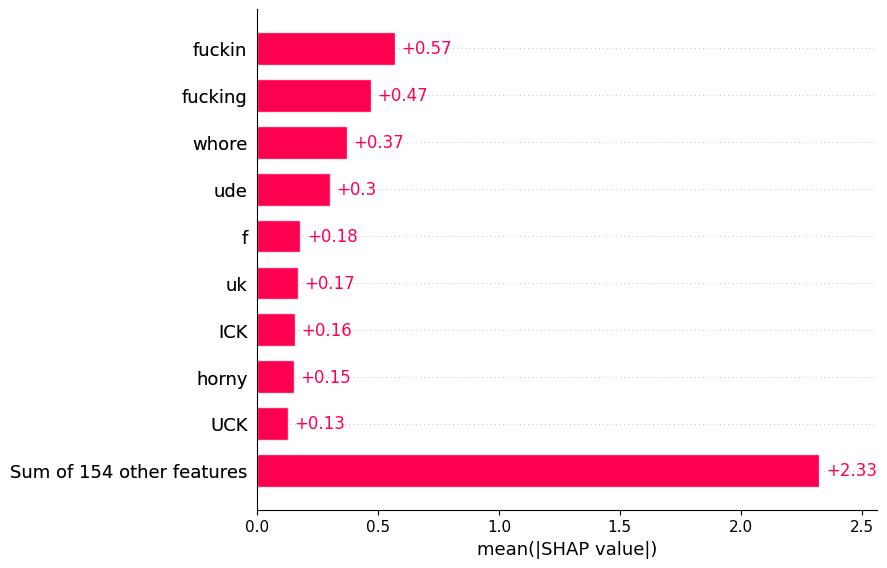

In [24]:
shap.plots.bar(shap_values[:, :, "offensive"])

In [25]:
shap_values = explainer(sorted_neutral_tweets[:10])
# Visualize prediction's explanation for the non-offensive output class
shap.plots.text(shap_values[:3, :, "non-offensive"])

  0%|          | 0/90 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 3/10 [01:43<05:13, 44.83s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 4/10 [02:04<03:29, 34.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 5/10 [03:58<05:21, 64.36s/it]

  0%|          | 0/72 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 6/10 [04:07<02:59, 44.98s/it]

  0%|          | 0/42 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 7/10 [04:15<01:38, 32.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 9/10 [06:07<00:40, 40.34s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 10/10 [06:13<00:00, 29.79s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

Partition explainer: 11it [06:44, 40.47s/it]


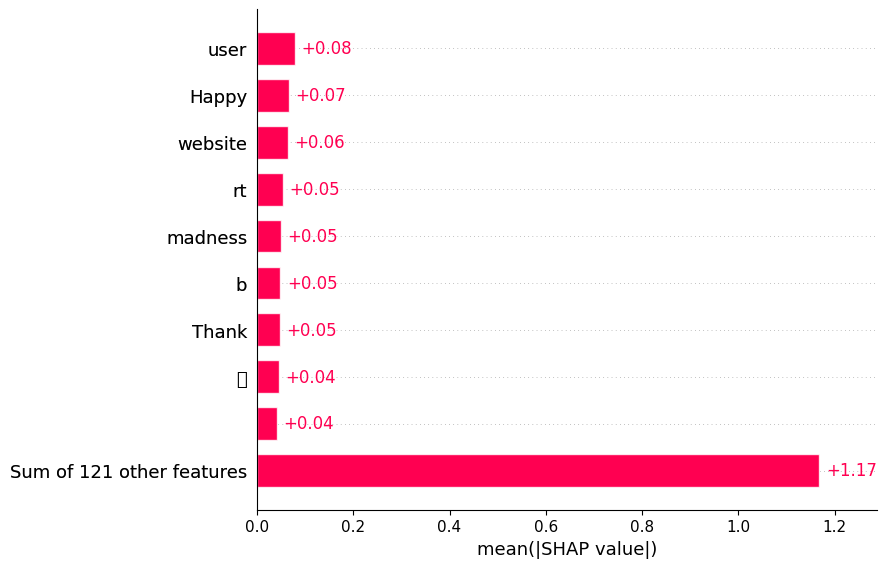

In [26]:
shap.plots.bar(shap_values[:, :, "non-offensive"])

Let's analyse some of the result :

If we take this topic: **`Absolutely fuckin gorgeous 😍😍`**

We can see that the model associates 'fuckin' with offensive content, but in the overall context of this tweet, we can assume that the user is paying a compliment, which is therefore not offensive. The model is therefore biased by the use of this word.

You can also look at the following text: **`keep my name out of your mouth 😒`**

This tweet doesn't contain any offensive words apart from maybe the emoji but the model is uncertain about that while clearly this message can be classified as offensive.

## Advantages of using a pre-trained transformer vs naive Bayes

### Training

* **Accuracy:** Pre-trained transformers are typically more accurate than naive Bayes models, even when trained on the same dataset. This is because transformers are able to learn long-range dependencies between words, which is important for understanding the context of text. Naive Bayes, on the other hand, is a simple statistical model that does not take into account long-range dependencies.
* **Speed:** Pre-trained transformers can be trained much faster than naive Bayes models. This is because transformers can be trained on a massive dataset of text in parallel, while naive Bayes models must be trained sequentially.
* **Data requirements:** Pre-trained transformers require a large dataset of text to train, but this dataset can be reused for multiple tasks. Naive Bayes models, on the other hand, require a separate dataset for each task.

### Usage in production

* **Accuracy:** Pre-trained transformers are typically more accurate than naive Bayes models in production. This is because transformers are able to learn from a wider variety of data, and they are less likely to be biased by the training data.
* **Speed:** Pre-trained transformers can be used to classify text much faster than naive Bayes models. This is because transformers have been pre-trained on a massive dataset of text, which allows them to learn the statistical relationships between words very efficiently.
* **Ease of use:** Pre-trained transformers are relatively easy to use. They can be implemented in a variety of programming languages, and there are many pre-trained models available that can be used out-of-the-box. Naive Bayes, on the other hand, can be more difficult to implement and use.

**Summary**

Pre-trained transformers offer a number of advantages over naive Bayes for both training and usage in production. They are more accurate, faster, and easier to use. However, it is important to note that **naive Bayes can still be a good choice for some tasks**, such as when **accuracy is not as important as speed or ease of use.**

**Table**

| Feature | Pre-trained transformer | Naive Bayes |
|---|---|---|
| Accuracy | **Higher** | **Lower** |
| Speed | **Faster** | **Slower** |
| Ease of use | **Easier** | **More difficult** |
| Data requirements | **Less** | **More** |


## [BONUS] 6. Train a naive Bayes model on the data

In [27]:
# Preprocess the data
train_data = tweet_dataset["train"]
X_train = train_data["text"]
y_train = np.array([int(label) for label in train_data["label"]])

# Create a CountVectorizer to convert text into numeric features
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

# Train the naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vec, y_train)


MultinomialNB()

In [28]:
# Preprocess the test data
test_data = tweet_dataset["test"]
X_test = test_data["text"]
y_test = np.array([int(label) for label in test_data["label"]])

# Convert the test data into numeric features
X_test_vec = vectorizer.transform(X_test)


# Predict using the naive Bayes model
y_pred_naive_bayes = naive_bayes_model.predict(X_test_vec)

# Generate classification report
classification_report_naive_bayes = classification_report(y_test, y_pred_naive_bayes)
print(classification_report_naive_bayes)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       620
           1       0.62      0.56      0.59       240

    accuracy                           0.78       860
   macro avg       0.73      0.71      0.72       860
weighted avg       0.78      0.78      0.78       860



Previous model scores:

- Precision: 0.80
- Recall: 0.67
- F1-score: 0.73

Comparing the two results, we can see that the two models perform very similarly, although the Cardiff model seems to outperform the naive Bayes model. On the other hand, the latter has a better recall than the Cardiff model.

# Data annotation

## 1. Tweet extraction

In [29]:
# Load the pretrained model and tokenizer
checkpoint = "cardiffnlp/twitter-roberta-base-offensive"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Preprocess and classify the tweets
offensive_tweets = []
for tweet in tweets:
    text = tweet["text"]
    encoded_input = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    with torch.no_grad():
        logits = model(**encoded_input).logits
        probabilities = torch.softmax(logits, dim=1)
        _, predicted_label = torch.max(probabilities, dim=1)
        if predicted_label.item() == 1 and probabilities[0][1].item() >= 0.2:
            offensive_tweets.append(text)
        if len(offensive_tweets) >= 100:
            break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [30]:
# Create a DataFrame from the offensive_tweets list
df = pd.DataFrame(offensive_tweets)

# Save the DataFrame to an Excel file
df.to_excel("offensive_tweets.xlsx", index=False)

## 2. Annotation guideline

## Annotation Guideline for Offensive Tweets

### Target Class

The target class is tweets that are offensive. Offensive tweets are those that are intended to cause harm or offense to others. This can include tweets that are racist, sexist, homophobic, or otherwise discriminatory. It can also include tweets that are threatening, violent, or hateful.

### Context

It is important to consider the context of a tweet when determining whether it is offensive. For example, a tweet that contains a swear word may not be offensive if it is used in a joking or ironic way. Similarly, a tweet that makes a reference to a sensitive topic may not be offensive if it is done in a respectful way.

### Intent

It is also important to consider the intent of the tweet's author when determining whether it is offensive. For example, a tweet that contains a swear word may not be offensive if the author is simply using it as a form of expression. However, if the author is using the swear word to insult or offend someone, then it would be considered offensive.

### Audience

The audience of a tweet can also play a role in determining whether it is offensive. For example, a tweet that would be considered offensive in one context may not be offensive in another context. For example, a tweet that makes a reference to a sensitive topic may not be offensive if it is directed at a group of people who are familiar with the topic. However, if the tweet is directed at a group of people who are not familiar with the topic, then it could be considered offensive.

### "Can't tell / not annotatable" class

This class should be used for tweets that are not clear enough to be annotated. This could include tweets that are too short, tweets that are in a foreign language, or tweets that are simply not understandable.

### Examples

* **Offensive:**
    * "Black people are lazy."
    * "Women should stay in the kitchen."
    * "I'm going to kill all the Jews."
    * "This is a threat to kill someone."
    * "This is a tweet that promotes violence against a group of people."
* **Ambiguous:**
    * "That's a gay joke."
    * "I'm not sure if this is offensive or not."
    * "This tweet makes a reference to a sensitive topic, but I don't think it's offensive."

### Additional considerations

* **Cultural context:** It is important to consider the cultural context of a tweet when determining whether it is offensive. For example, a tweet that would be considered offensive in one culture may not be offensive in another culture.
* **Humor:** It is important to consider the intent of the tweet's author when determining whether it is offensive. For example, a tweet that contains a swear word may not be offensive if the author is simply using it as a form of expression. However, if the author is using the swear word to insult or offend someone, then it would be considered offensive.
* **Frequency:** The frequency of a tweet can also play a role in determining whether it is offensive. For example, a tweet that contains a swear word may not be offensive if it is used infrequently. However, if the swear word is used frequently, then it could be considered offensive.


## 3. Annotation result

Let's take a look at the result of our annotation :

In [3]:
annotated_df = pd.read_excel("offensive_tweets_annotated.xlsx")
annotated_df.head(10)

,Tweets,Antoine,Habib,Julian
0,YOU BETTER SUCK HIS DICK KOZY I SEE YOU WITH K...,1,1,1
1,Fuckof,-1,1,-1
2,Dude you could've just saved the image as a png,0,0,0
3,"Make up, dress up, like a princess \nfor him s...",-1,-1,-1
4,Nigga said Da Baby look like a PT Cruiser No f...,-1,0,0
5,you calling me pissbaby summoned me here ihy,0,0,0
6,keep my name out of your mouth 😒,0,1,1
7,Absolutely fuckin gorgeous 😍,0,0,0
8,no but fr they rlly had a 6+ hour standoff wit...,0,-1,-1
9,setiap lihat teman2ku baru main hades and they...,0,0,0


## 4. Evaluate our inter-annotator agreement using Fleiss Kappa.

In [4]:
annotations = annotated_df.iloc[:, 1:].values  # Extracting annotation columns as a NumPy array
data, cats = aggregate_raters(annotations)

# Calculate Fleiss' Kappa
kappa  = fleiss_kappa(data)

# Print the result
print(f"Fleiss' Kappa score : {kappa}")

Fleiss' Kappa score : 0.648999648999649


With a **Fleiss' Kappa score of approximately 0.65**, it suggests that there is a substantial level of agreement among us in classifying the tweets as offensive or not offensive. While not perfect, it still demonstrates a reasonably consistent level of agreement.

## [BONUS] 5. New iteration on our annotation guideline

## Updated Annotation Guideline for Offensive Tweets
### Target Class

The target class is tweets that are offensive. Offensive tweets are those that are intended to cause harm or offense to others. This can include tweets that are racist, sexist, homophobic, or otherwise discriminatory. It can also include tweets that are threatening, violent, or hateful.

### Context

It is important to consider the context of a tweet when determining whether it is offensive. For example, a tweet that contains a swear word may not be offensive if it is used in a joking or ironic way. Similarly, a tweet that makes a reference to a sensitive topic may not be offensive if it is done in a respectful way.
Intent

It is also important to consider the intent of the tweet's author when determining whether it is offensive. For example, a tweet that contains a swear word may not be offensive if the author is simply using it as a form of expression. However, if the author is using the swear word to insult or offend someone, then it would be considered offensive.
Audience

The audience of a tweet can also play a role in determining whether it is offensive. For example, a tweet that would be considered offensive in one context may not be offensive in another context. It's important to consider the potential impact of the tweet on its intended audience and the general public.
"Can't tell / not annotatable" class

This class should be used for tweets that are not clear enough to be annotated. This could include tweets that are too short, tweets that are in a foreign language, or tweets that are simply not understandable.

### Examples

**Offensive:**
- "Black people are lazy."
- "Women should stay in the kitchen."
- "I'm going to kill all the Jews."
- "This is a threat to kill someone."
- "This tweet promotes violence against a specific group of people."

**Ambiguous:**
- "That's a gay joke."
- "I'm not sure if this is offensive or not."
- "This tweet makes a reference to a sensitive topic, but I don't th- it's offensive."

### Additional considerations

- **Cultural context:** It is important to consider the cultural context of a tweet when determining whether it is offensive. What may be considered offensive in one culture may not be offensive in another. Take cultural sensitivities into account.
- **Humor and sarcasm:** Consider the intent and tone of the tweet. Humor and sarcasm can sometimes be difficult to interpret, so carefully analyze the context and author's intention.

- **Frequency and severity:** Evaluate the frequency and severity of offensive language or content within a tweet. Frequent or severe use may contribute to its offensiveness.

- **Individual impact:** Assess how the tweet might impact individuals or specific groups. Consider potential harm or offense caused by discriminatory language or content.

## [BONUS] 6. Evaluate the model on our data

In [5]:
original_data = annotated_df.copy()

# Preprocess the data (remove "can't tell" instances)
preprocessed_data = original_data[(original_data["Antoine"] != -1) & (original_data["Habib"] != -1) & (original_data["Julian"] != -1)]

# Compute majority vote labels
majority_vote_labels = np.array(preprocessed_data.iloc[:, 1:4].mode(axis=1))

tweets_list = preprocessed_data["Tweets"].values.tolist()

# Tokenize the tweets
checkpoint = "cardiffnlp/twitter-roberta-base-offensive"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenized_inputs = tokenizer(tweets_list, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Run model inference
outputs = model(**tokenized_inputs)
predicted_labels = torch.argmax(outputs.logits, dim=1).detach().numpy()

In [6]:
# Calculate evaluation metrics
precision = precision_score(majority_vote_labels, predicted_labels, average="binary")
recall = recall_score(majority_vote_labels, predicted_labels, average="binary")
f1 = f1_score(majority_vote_labels, predicted_labels, average="binary")

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.3500
Recall: 1.0000
F1-score: 0.5185


Our model performs rather poorly on annotated data in terms of precision and f1-score. This could be explained by the small number of data (less than 100) or a problem in the annotations. It should also be noted that we have removed all tweets where the model is not certain of their class.